https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

In [1]:
import torch
import pandas as pd
import numpy as np
import nltk
import re

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/patrick.araujo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrick.araujo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/patrick.araujo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
id = 7

In [4]:
if torch.cuda.is_available():
    GPU = torch.cuda.get_device_name(id)
    print(f"PyTorch available GPU: {GPU}")
else:
    print("GPU not available")

PyTorch available GPU: Quadro RTX 8000


In [5]:
torch.cuda.device_count()

8

In [6]:
device = torch.device(f"cuda:{id}" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:7


In [7]:
# device = torch.device("cpu")
# print(f'Device: {device}')

In [8]:
dataset = pd.read_csv('/home/patrick.araujo/llama2/datasets/balanced_output.csv')

In [9]:
dataset

,level_0,index,Unnamed: 0,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language
0,2812,4087,4087,7c7a7fe6-f187-48c6-823a-70ae734b04a3,"the app runs a little slow at times, but nothi...",5,5,26.23.0.100,2023-12-09 10:57:59,NaN,NaN,26.23.0.100,2,145,en
1,17483,24985,24985,c76ab0e8-50f0-48ec-a920-9de9329299fa,You do realize there is more than just apple S...,3,0,22.19.0.100,2022-05-06 03:05:51,NaN,NaN,22.19.0.100,1,379,en
2,7525,10956,10956,5cd981cf-c9be-45ee-b0e3-92af3d7c2a12,"Easy to use if you know what you want, simple ...",5,2,26.21.0.100,2023-11-01 11:15:01,NaN,NaN,26.21.0.100,2,208,en
3,7019,10263,10263,74daab50-f012-4d3d-a880-9a3f0e4fd159,Work ok but frozen on loading and searching as...,3,1,26.21.0.100,2023-11-05 12:08:47,NaN,NaN,26.21.0.100,1,52,en
4,8328,12432,12432,af3b1dfc-9982-49d2-ab96-d06f2b9ae9a6,easy shopping and fast delivery,5,0,26.19.4.100,2023-10-10 17:42:38,NaN,NaN,26.19.4.100,2,31,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11626,4226,6159,6159,6eb97318-ab71-4b6c-a7af-d486bc38953a,love it can always find what I need and great ...,5,0,26.20.0.100,2023-11-24 15:20:22,NaN,NaN,26.20.0.100,2,83,en
11627,9673,14414,14414,0e6be9a1-7922-431e-b202-2907cfbaae87,The app is SLOW and not intuitive at all! Sear...,2,0,26.15.0.100,2023-08-09 07:22:09,NaN,NaN,26.15.0.100,0,298,en
11628,3504,5093,5093,37341abd-e64f-4e4e-af5f-1148dfc23a31,Love Amazon if you're not happy with a purchas...,5,1,26.22.0.100,2023-12-01 21:41:25,NaN,NaN,26.22.0.100,2,221,en
11629,15987,22652,22652,6f9ccf0a-bb3d-4490-9b30-a1c5e0e62f18,Less cumbersomely awkward. Improved member con...,3,0,24.5.2.100,2022-08-04 06:18:49,NaN,NaN,24.5.2.100,1,63,en


In [10]:
dataset.shape

(11631, 15)

In [11]:
sentiment_counts_balanced = dataset['sentiment'].value_counts().sort_index()
print(sentiment_counts_balanced)

sentiment
0    3877
1    3877
2    3877
Name: count, dtype: int64


In [12]:
dataset['pre_process'] = dataset['content'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

In [13]:
from bs4 import BeautifulSoup

dataset['pre_process'] = dataset['pre_process'].apply(lambda x: BeautifulSoup(x).get_text())

/tmp/ipykernel_2202620/1601252331.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  dataset['pre_process'] = dataset['pre_process'].apply(lambda x: BeautifulSoup(x).get_text())


In [14]:
import re
dataset['pre_process'] = dataset['pre_process'].apply(lambda x: re.sub(r"http\S+", "", x))

In [15]:
def contractions(s):
 s = re.sub(r"won't", "will not",s)
 s = re.sub(r"would't", "would not",s)
 s = re.sub(r"could't", "could not",s)
 s = re.sub(r"\'d", " would",s)
 s = re.sub(r"can\'t", "can not",s)
 s = re.sub(r"n\'t", " not", s)
 s= re.sub(r"\'re", " are", s)
 s = re.sub(r"\'s", " is", s)
 s = re.sub(r"\'ll", " will", s)
 s = re.sub(r"\'t", " not", s)
 s = re.sub(r"\'ve", " have", s)
 s = re.sub(r"\'m", " am", s)
 return s

In [16]:
dataset['pre_process']=dataset['pre_process'].apply(lambda x:contractions(x))

In [17]:
dataset['pre_process']=dataset['pre_process'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [18]:
dataset['pre_process']=dataset['pre_process'].apply(lambda x: re.sub(' +', ' ', x))

In [19]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
dataset['pre_process']=dataset['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

In [20]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
dataset['pre_process'] = dataset['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [21]:
dataset

,level_0,index,Unnamed: 0,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,pre_process
0,2812,4087,4087,7c7a7fe6-f187-48c6-823a-70ae734b04a3,"the app runs a little slow at times, but nothi...",5,5,26.23.0.100,2023-12-09 10:57:59,NaN,NaN,26.23.0.100,2,145,en,app run little slow time nothing worth taking ...
1,17483,24985,24985,c76ab0e8-50f0-48ec-a920-9de9329299fa,You do realize there is more than just apple S...,3,0,22.19.0.100,2022-05-06 03:05:51,NaN,NaN,22.19.0.100,1,379,en,realize apple samsung motorola see lg lg make ...
2,7525,10956,10956,5cd981cf-c9be-45ee-b0e3-92af3d7c2a12,"Easy to use if you know what you want, simple ...",5,2,26.21.0.100,2023-11-01 11:15:01,NaN,NaN,26.21.0.100,2,208,en,easy use know want simple find select item ord...
3,7019,10263,10263,74daab50-f012-4d3d-a880-9a3f0e4fd159,Work ok but frozen on loading and searching as...,3,1,26.21.0.100,2023-11-05 12:08:47,NaN,NaN,26.21.0.100,1,52,en,work ok frozen loading searching well
4,8328,12432,12432,af3b1dfc-9982-49d2-ab96-d06f2b9ae9a6,easy shopping and fast delivery,5,0,26.19.4.100,2023-10-10 17:42:38,NaN,NaN,26.19.4.100,2,31,en,easy shopping fast delivery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11626,4226,6159,6159,6eb97318-ab71-4b6c-a7af-d486bc38953a,love it can always find what I need and great ...,5,0,26.20.0.100,2023-11-24 15:20:22,NaN,NaN,26.20.0.100,2,83,en,love always find need great delivery time easy...
11627,9673,14414,14414,0e6be9a1-7922-431e-b202-2907cfbaae87,The app is SLOW and not intuitive at all! Sear...,2,0,26.15.0.100,2023-08-09 07:22:09,NaN,NaN,26.15.0.100,0,298,en,app slow intuitive searching item website sooo...
11628,3504,5093,5093,37341abd-e64f-4e4e-af5f-1148dfc23a31,Love Amazon if you're not happy with a purchas...,5,1,26.22.0.100,2023-12-01 21:41:25,NaN,NaN,26.22.0.100,2,221,en,love amazon happy purchase change mind thing r...
11629,15987,22652,22652,6f9ccf0a-bb3d-4490-9b30-a1c5e0e62f18,Less cumbersomely awkward. Improved member con...,3,0,24.5.2.100,2022-08-04 06:18:49,NaN,NaN,24.5.2.100,1,63,en,le cumbersomely awkward improved member conten...


Feature Extraction

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train, Y_test = train_test_split(dataset['pre_process'], dataset['sentiment'], test_size=0.2, random_state=30)

print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

Train:  (9304,) (9304,) Test:  ((2327,), (2327,))


SVM

In [23]:
# from sklearn.svm import LinearSVC
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer

# print("TFIDF Vectorizer……")

# # Define your pipeline including feature extraction and classifier
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('clf', LinearSVC(random_state=0)),
# ])

# # Fit the pipeline
# pipeline.fit(X_train, Y_train)

# # Evaluate on test data
# y_test_pred = pipeline.predict(X_test)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("TFIDF Vectorizer……")

vectorizer= TfidfVectorizer()

tf_x_train = vectorizer.fit_transform(X_train)

tf_x_test = vectorizer.transform(X_test)

TFIDF Vectorizer……


In [25]:
from sklearn.svm import SVC

clf_svm = SVC(random_state=0)

In [26]:
# clf.fit(tf_x_train,Y_train)

In [27]:
# y_test_pred=clf.predict(tf_x_test)

In [28]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(clf_svm, param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(tf_x_train, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.493 total time=  10.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.461 total time=  10.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.471 total time=   9.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.477 total time=  10.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.502 total time=  10.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.409 total time=  10.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.401 total time=  10.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.416 total time=  10.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.418 total time=  10.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.426 total time=  10.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.334 total time=  10.8s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(random_state=0),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [29]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
best_estimator = grid.best_estimator_
print(best_estimator)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1, random_state=0)


In [30]:
from joblib import dump, load

# Saving the best estimator found by GridSearchCV
dump(best_estimator, 'svm_best_model.joblib')

['svm_best_model.joblib']

In [33]:
from sklearn.metrics import classification_report, balanced_accuracy_score

grid_predictions = grid.predict(tf_x_test)

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(Y_test, grid_predictions)

# Generate classification report
report = classification_report(Y_test, grid_predictions, output_dict=True)

# Add balanced accuracy to the report
report['weighted avg']['balanced_accuracy'] = balanced_acc

In [34]:
# Print the modified classification report
report

{'0': {'precision': 0.6030341340075853,
  'recall': 0.6194805194805195,
  'f1-score': 0.6111467008327995,
  'support': 770.0},
 '1': {'precision': 0.4901277584204414,
  'recall': 0.5523560209424084,
  'f1-score': 0.5193846153846153,
  'support': 764.0},
 '2': {'precision': 0.7866666666666666,
  'recall': 0.669609079445145,
  'f1-score': 0.723433242506812,
  'support': 793.0},
 'accuracy': 0.6145251396648045,
 'macro avg': {'precision': 0.6266095196982311,
  'recall': 0.6138152066226911,
  'f1-score': 0.6179881862414089,
  'support': 2327.0},
 'weighted avg': {'precision': 0.6285434281416952,
  'recall': 0.6145251396648045,
  'f1-score': 0.6192846442213167,
  'support': 2327.0,
  'balanced_accuracy': 0.6138152066226911}}

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

unique_labels = dataset['sentiment'].unique()
conf_matrix = confusion_matrix(Y_test, grid_predictions, labels=unique_labels)

In [36]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[531 184  78]
 [106 422 236]
 [ 38 255 477]]


In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)

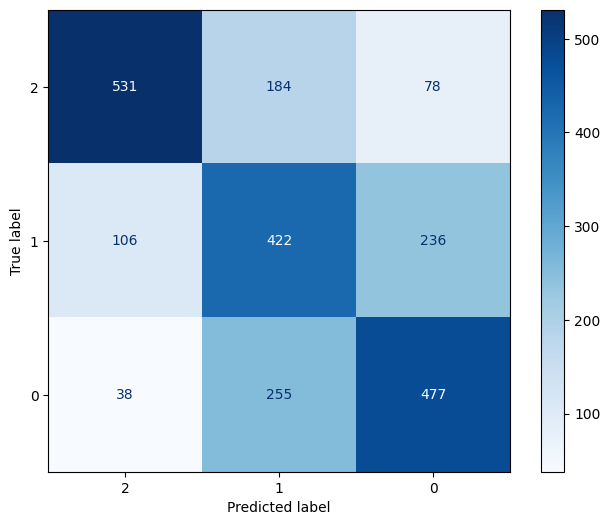

In [38]:
import matplotlib.pyplot as plt
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)

# Save the plot as an image file (e.g., PNG)
plt.savefig('confusion_matrix_TFIDF_SVM.png')
plt.savefig('confusion_matrix_TFIDF_SVM.svg')

# Optionally, display the plot
plt.show()

#**Precision, Recall, F1-score, Support**:

**Precision**:
Precision measures the accuracy of the positive predictions. Recall measures the ability of the classifier to find all the positive samples. F1-score is the harmonic mean of precision and recall, providing a balanced measure between them. Support indicates the number of actual occurrences of each class in the test dataset.
For both classifiers, there are precision, recall, and F1-score calculated for each sentiment class (positive, negative, neutral).

**Accuracy**: Accuracy measures the overall correctness of the predictions made by the classifier across all classes.

**Comparative Analysis**: Looking at the individual metrics for each sentiment class, you can compare how well each classifier performed in distinguishing between positive, negative, and neutral sentiments.

**Interpretation**: These results suggest that the Logistic Regression classifier performs slightly better overall compared to the SVM classifier in terms of accuracy. However, the performance can vary depending on the specific dataset and the characteristics of the text data being analyzed.
It's essential to consider not only accuracy but also precision, recall, and F1-score for each class to understand the classifier's performance comprehensively, especially in cases where class distribution is imbalanced.


Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)

In [40]:
# Define the parameter grid to search
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  # solvers that support penalty='l1'
}

In [41]:
# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=3, scoring='accuracy')

In [42]:
# Fit GridSearchCV
grid_search.fit(tf_x_train, Y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=9.999999999999999e-05, penalty=l1, solver=liblinear;, score=0.334 total time=   0.0s
[CV 2/5] END C=9.999999999999999e-05, penalty=l1, solver=liblinear;, score=0.334 total time=   0.0s
[CV 3/5] END C=9.999999999999999e-05, penalty=l1, solver=liblinear;, score=0.334 total time=   0.0s
[CV 4/5] END C=9.999999999999999e-05, penalty=l1, solver=liblinear;, score=0.334 total time=   0.0s
[CV 5/5] END C=9.999999999999999e-05, penalty=l1, solver=liblinear;, score=0.334 total time=   0.0s
[CV 1/5] END C=9.999999999999999e-05, penalty=l1, solver=saga;, score=0.332 total time=   0.0s
[CV 2/5] END C=9.999999999999999e-05, penalty=l1, solver=saga;, score=0.334 total time=   0.0s
[CV 3/5] END C=9.999999999999999e-05, penalty=l1, solver=saga;, score=0.332 total time=   0.0s
[CV 4/5] END C=9.999999999999999e-05, penalty=l1, solver=saga;, score=0.332 total time=   0.0s
[CV 5/5] END C=9.999999999999999e-05, penalty=l1, solver=s

/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=4.281332398719395, penalty=l1, solver=liblinear;, score=0.580 total time=   9.2s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=4.281332398719395, penalty=l1, solver=saga;, score=0.548 total time= 1.2min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=4.281332398719395, penalty=l1, solver=saga;, score=0.536 total time= 1.4min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=4.281332398719395, penalty=l1, solver=saga;, score=0.564 total time= 1.2min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=4.281332398719395, penalty=l1, solver=saga;, score=0.550 total time= 1.4min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=4.281332398719395, penalty=l1, solver=saga;, score=0.572 total time= 1.2min
[CV 1/5] END C=4.281332398719395, penalty=l2, solver=liblinear;, score=0.576 total time=   0.1s
[CV 2/5] END C=4.281332398719395, penalty=l2, solver=liblinear;, score=0.580 total time=   0.1s
[CV 3/5] END C=4.281332398719395, penalty=l2, solver=liblinear;, score=0.586 total time=   0.1s
[CV 4/5] END C=4.281332398719395, penalty=l2, solver=liblinear;, score=0.572 total time=   0.1s
[CV 5/5] END C=4.281332398719395, penalty=l2, solver=liblinear;, score=0.599 total time=   0.1s
[CV 1/5] END C=4.281332398719395, penalty=l2, solver=saga;, score=0.569 total time=   0.2s
[CV 2/5] END C=4.281332398719395, penalty=l2, solver=saga;, score=0.564 total time=   0.2s
[CV 3/5] END C=4.281332398719395, penalty=l2, solver=saga;, score=0.584 total time=   0.2s
[CV 4/5] END C=4.281332398719395, penalty=l2, solver=saga;, score=0.565 total time=   0.2s
[CV 5/5] END C=4.281332398719395, penalty=l2, solver=saga;, score

/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=11.288378916846883, penalty=l1, solver=saga;, score=0.539 total time= 2.2min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=11.288378916846883, penalty=l1, solver=saga;, score=0.533 total time= 2.1min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=11.288378916846883, penalty=l1, solver=saga;, score=0.541 total time= 2.0min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=11.288378916846883, penalty=l1, solver=saga;, score=0.535 total time= 2.1min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=11.288378916846883, penalty=l1, solver=saga;, score=0.553 total time= 2.2min
[CV 1/5] END C=11.288378916846883, penalty=l2, solver=liblinear;, score=0.565 total time=   0.2s
[CV 2/5] END C=11.288378916846883, penalty=l2, solver=liblinear;, score=0.557 total time=   0.2s
[CV 3/5] END C=11.288378916846883, penalty=l2, solver=liblinear;, score=0.570 total time=   0.2s
[CV 4/5] END C=11.288378916846883, penalty=l2, solver=liblinear;, score=0.556 total time=   0.2s
[CV 5/5] END C=11.288378916846883, penalty=l2, solver=liblinear;, score=0.584 total time=   0.2s
[CV 1/5] END C=11.288378916846883, penalty=l2, solver=saga;, score=0.559 total time=   0.4s
[CV 2/5] END C=11.288378916846883, penalty=l2, solver=saga;, score=0.540 total time=   0.3s
[CV 3/5] END C=11.288378916846883, penalty=l2, solver=saga;, score=0.564 total time=   0.3s
[CV 4/5] END C=11.288378916846883, penalty=l2, solver=saga;, score=0.550 total time=   0.3s
[CV 5/5] END C=11.288378916846883, penalty=l2, solver=s

/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=29.76351441631313, penalty=l1, solver=saga;, score=0.526 total time= 3.0min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=29.76351441631313, penalty=l1, solver=saga;, score=0.509 total time= 3.0min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=29.76351441631313, penalty=l1, solver=saga;, score=0.521 total time= 3.1min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=29.76351441631313, penalty=l1, solver=saga;, score=0.516 total time= 3.0min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=29.76351441631313, penalty=l1, solver=saga;, score=0.538 total time= 3.0min
[CV 1/5] END C=29.76351441631313, penalty=l2, solver=liblinear;, score=0.559 total time=   0.2s
[CV 2/5] END C=29.76351441631313, penalty=l2, solver=liblinear;, score=0.535 total time=   0.3s
[CV 3/5] END C=29.76351441631313, penalty=l2, solver=liblinear;, score=0.554 total time=   0.2s
[CV 4/5] END C=29.76351441631313, penalty=l2, solver=liblinear;, score=0.539 total time=   0.2s
[CV 5/5] END C=29.76351441631313, penalty=l2, solver=liblinear;, score=0.575 total time=   0.3s
[CV 1/5] END C=29.76351441631313, penalty=l2, solver=saga;, score=0.544 total time=   0.7s
[CV 2/5] END C=29.76351441631313, penalty=l2, solver=saga;, score=0.529 total time=   0.8s
[CV 3/5] END C=29.76351441631313, penalty=l2, solver=saga;, score=0.546 total time=   0.7s
[CV 4/5] END C=29.76351441631313, penalty=l2, solver=saga;, score=0.534 total time=   0.8s
[CV 5/5] END C=29.76351441631313, penalty=l2, solver=saga;, score

/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=78.47599703514607, penalty=l1, solver=saga;, score=0.514 total time= 4.3min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=78.47599703514607, penalty=l1, solver=saga;, score=0.510 total time= 4.4min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=78.47599703514607, penalty=l1, solver=saga;, score=0.506 total time= 4.3min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=78.47599703514607, penalty=l1, solver=saga;, score=0.503 total time= 4.5min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=78.47599703514607, penalty=l1, solver=saga;, score=0.527 total time= 4.3min
[CV 1/5] END C=78.47599703514607, penalty=l2, solver=liblinear;, score=0.543 total time=   0.3s
[CV 2/5] END C=78.47599703514607, penalty=l2, solver=liblinear;, score=0.526 total time=   0.3s
[CV 3/5] END C=78.47599703514607, penalty=l2, solver=liblinear;, score=0.544 total time=   0.4s
[CV 4/5] END C=78.47599703514607, penalty=l2, solver=liblinear;, score=0.523 total time=   0.3s
[CV 5/5] END C=78.47599703514607, penalty=l2, solver=liblinear;, score=0.551 total time=   0.3s
[CV 1/5] END C=78.47599703514607, penalty=l2, solver=saga;, score=0.539 total time=   1.4s
[CV 2/5] END C=78.47599703514607, penalty=l2, solver=saga;, score=0.521 total time=   1.4s
[CV 3/5] END C=78.47599703514607, penalty=l2, solver=saga;, score=0.535 total time=   1.4s
[CV 4/5] END C=78.47599703514607, penalty=l2, solver=saga;, score=0.524 total time=   1.5s
[CV 5/5] END C=78.47599703514607, penalty=l2, solver=saga;, score

/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=206.913808111479, penalty=l1, solver=saga;, score=0.498 total time= 6.5min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=206.913808111479, penalty=l1, solver=saga;, score=0.508 total time= 6.3min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=206.913808111479, penalty=l1, solver=saga;, score=0.499 total time= 6.3min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=206.913808111479, penalty=l1, solver=saga;, score=0.503 total time= 6.6min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=206.913808111479, penalty=l1, solver=saga;, score=0.523 total time= 6.4min
[CV 1/5] END C=206.913808111479, penalty=l2, solver=liblinear;, score=0.536 total time=   0.3s
[CV 2/5] END C=206.913808111479, penalty=l2, solver=liblinear;, score=0.515 total time=   0.3s
[CV 3/5] END C=206.913808111479, penalty=l2, solver=liblinear;, score=0.533 total time=   0.4s
[CV 4/5] END C=206.913808111479, penalty=l2, solver=liblinear;, score=0.517 total time=   0.3s
[CV 5/5] END C=206.913808111479, penalty=l2, solver=liblinear;, score=0.542 total time=   0.3s
[CV 1/5] END C=206.913808111479, penalty=l2, solver=saga;, score=0.523 total time=   1.8s
[CV 2/5] END C=206.913808111479, penalty=l2, solver=saga;, score=0.515 total time=   2.1s
[CV 3/5] END C=206.913808111479, penalty=l2, solver=saga;, score=0.521 total time=   2.8s
[CV 4/5] END C=206.913808111479, penalty=l2, solver=saga;, score=0.509 total time=   2.8s
[CV 5/5] END C=206.913808111479, penalty=l2, solver=saga;, score=0.535 tota

/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=545.5594781168514, penalty=l1, solver=saga;, score=0.499 total time= 8.5min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=545.5594781168514, penalty=l1, solver=saga;, score=0.508 total time= 8.1min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=545.5594781168514, penalty=l1, solver=saga;, score=0.497 total time= 8.3min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=545.5594781168514, penalty=l1, solver=saga;, score=0.495 total time= 8.9min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=545.5594781168514, penalty=l1, solver=saga;, score=0.518 total time= 9.4min
[CV 1/5] END C=545.5594781168514, penalty=l2, solver=liblinear;, score=0.520 total time=   0.6s
[CV 2/5] END C=545.5594781168514, penalty=l2, solver=liblinear;, score=0.508 total time=   0.6s
[CV 3/5] END C=545.5594781168514, penalty=l2, solver=liblinear;, score=0.516 total time=   0.6s
[CV 4/5] END C=545.5594781168514, penalty=l2, solver=liblinear;, score=0.506 total time=   0.7s
[CV 5/5] END C=545.5594781168514, penalty=l2, solver=liblinear;, score=0.531 total time=   0.6s
[CV 1/5] END C=545.5594781168514, penalty=l2, solver=saga;, score=0.513 total time=   4.8s
[CV 2/5] END C=545.5594781168514, penalty=l2, solver=saga;, score=0.513 total time=   4.5s
[CV 3/5] END C=545.5594781168514, penalty=l2, solver=saga;, score=0.509 total time=   3.5s
[CV 4/5] END C=545.5594781168514, penalty=l2, solver=saga;, score=0.505 total time=   3.3s
[CV 5/5] END C=545.5594781168514, penalty=l2, solver=saga;, score

/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1438.4498882876599, penalty=l1, solver=saga;, score=0.498 total time=10.4min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1438.4498882876599, penalty=l1, solver=saga;, score=0.506 total time=10.5min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1438.4498882876599, penalty=l1, solver=saga;, score=0.495 total time=10.6min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1438.4498882876599, penalty=l1, solver=saga;, score=0.493 total time=10.1min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1438.4498882876599, penalty=l1, solver=saga;, score=0.517 total time= 8.6min
[CV 1/5] END C=1438.4498882876599, penalty=l2, solver=liblinear;, score=0.513 total time=   0.4s
[CV 2/5] END C=1438.4498882876599, penalty=l2, solver=liblinear;, score=0.507 total time=   0.6s
[CV 3/5] END C=1438.4498882876599, penalty=l2, solver=liblinear;, score=0.505 total time=   0.7s
[CV 4/5] END C=1438.4498882876599, penalty=l2, solver=liblinear;, score=0.497 total time=   0.5s
[CV 5/5] END C=1438.4498882876599, penalty=l2, solver=liblinear;, score=0.523 total time=   0.6s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1438.4498882876599, penalty=l2, solver=saga;, score=0.500 total time=   3.4s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1438.4498882876599, penalty=l2, solver=saga;, score=0.509 total time=   3.3s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1438.4498882876599, penalty=l2, solver=saga;, score=0.501 total time=   3.4s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1438.4498882876599, penalty=l2, solver=saga;, score=0.501 total time=   3.3s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1438.4498882876599, penalty=l2, solver=saga;, score=0.519 total time=   3.3s
[CV 1/5] END C=3792.690190732246, penalty=l1, solver=liblinear;, score=0.466 total time=   4.0s
[CV 2/5] END C=3792.690190732246, penalty=l1, solver=liblinear;, score=0.480 total time=   2.9s
[CV 3/5] END C=3792.690190732246, penalty=l1, solver=liblinear;, score=0.469 total time=   3.4s
[CV 4/5] END C=3792.690190732246, penalty=l1, solver=liblinear;, score=0.476 total time=   3.1s
[CV 5/5] END C=3792.690190732246, penalty=l1, solver=liblinear;, score=0.502 total time=   3.1s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=3792.690190732246, penalty=l1, solver=saga;, score=0.501 total time= 9.2min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=3792.690190732246, penalty=l1, solver=saga;, score=0.506 total time= 9.4min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=3792.690190732246, penalty=l1, solver=saga;, score=0.495 total time= 9.3min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=3792.690190732246, penalty=l1, solver=saga;, score=0.494 total time= 9.4min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=3792.690190732246, penalty=l1, solver=saga;, score=0.515 total time= 9.5min
[CV 1/5] END C=3792.690190732246, penalty=l2, solver=liblinear;, score=0.506 total time=   0.6s
[CV 2/5] END C=3792.690190732246, penalty=l2, solver=liblinear;, score=0.504 total time=   0.7s
[CV 3/5] END C=3792.690190732246, penalty=l2, solver=liblinear;, score=0.500 total time=   1.0s
[CV 4/5] END C=3792.690190732246, penalty=l2, solver=liblinear;, score=0.491 total time=   1.0s
[CV 5/5] END C=3792.690190732246, penalty=l2, solver=liblinear;, score=0.517 total time=   0.8s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=3792.690190732246, penalty=l2, solver=saga;, score=0.500 total time=   3.2s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=3792.690190732246, penalty=l2, solver=saga;, score=0.509 total time=   3.2s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=3792.690190732246, penalty=l2, solver=saga;, score=0.495 total time=   3.3s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=3792.690190732246, penalty=l2, solver=saga;, score=0.498 total time=   3.2s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=3792.690190732246, penalty=l2, solver=saga;, score=0.520 total time=   3.3s
[CV 1/5] END C=10000.0, penalty=l1, solver=liblinear;, score=0.471 total time=   8.2s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=10000.0, penalty=l1, solver=liblinear;, score=0.465 total time= 6.2min
[CV 3/5] END C=10000.0, penalty=l1, solver=liblinear;, score=0.469 total time=   7.2s
[CV 4/5] END C=10000.0, penalty=l1, solver=liblinear;, score=0.474 total time=   5.2s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=10000.0, penalty=l1, solver=liblinear;, score=0.505 total time= 2.0min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10000.0, penalty=l1, solver=saga;, score=0.501 total time= 9.9min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10000.0, penalty=l1, solver=saga;, score=0.506 total time= 9.9min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10000.0, penalty=l1, solver=saga;, score=0.496 total time=10.0min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10000.0, penalty=l1, solver=saga;, score=0.492 total time=10.2min


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10000.0, penalty=l1, solver=saga;, score=0.514 total time= 9.9min
[CV 1/5] END C=10000.0, penalty=l2, solver=liblinear;, score=0.500 total time=   1.3s
[CV 2/5] END C=10000.0, penalty=l2, solver=liblinear;, score=0.500 total time=   1.3s
[CV 3/5] END C=10000.0, penalty=l2, solver=liblinear;, score=0.494 total time=   1.5s
[CV 4/5] END C=10000.0, penalty=l2, solver=liblinear;, score=0.485 total time=   1.5s
[CV 5/5] END C=10000.0, penalty=l2, solver=liblinear;, score=0.519 total time=   1.3s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10000.0, penalty=l2, solver=saga;, score=0.502 total time=   3.3s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10000.0, penalty=l2, solver=saga;, score=0.507 total time=   3.3s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10000.0, penalty=l2, solver=saga;, score=0.495 total time=   3.3s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10000.0, penalty=l2, solver=saga;, score=0.493 total time=   3.3s
[CV 5/5] END C=10000.0, penalty=l2, solver=saga;, score=0.517 total time=   3.3s


/home/patrick.araujo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=3)

In [43]:
# Review the best parameters and use them
print("Best parameters found: ", grid_search.best_params_)

lr_be = grid_search.best_estimator_
print("Best estimator: ", lr_be)

Best parameters found:  {'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.615848211066026, max_iter=1000, solver='liblinear')


In [44]:
dump(lr_be, 'lr_best_model.joblib')

['lr_best_model.joblib']

In [45]:
# Use the best estimator to make predictions
y_test_pred = grid_search.predict(tf_x_test)

In [46]:
# clf.fit(tf_x_train,Y_train)

In [47]:
# y_test_pred=clf.predict(tf_x_test)

In [48]:
# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(Y_test, y_test_pred)

# Generate classification report
report = classification_report(Y_test, y_test_pred, output_dict=True)

# Add balanced accuracy to the report
report['weighted avg']['balanced_accuracy'] = balanced_acc

In [49]:
# Print the modified classification report
report

{'0': {'precision': 0.6026731470230863,
  'recall': 0.6441558441558441,
  'f1-score': 0.6227244193345888,
  'support': 770.0},
 '1': {'precision': 0.49247606019151846,
  'recall': 0.4712041884816754,
  'f1-score': 0.4816053511705686,
  'support': 764.0},
 '2': {'precision': 0.7244501940491591,
  'recall': 0.7061790668348046,
  'f1-score': 0.7151979565772669,
  'support': 793.0},
 'accuracy': 0.6085088096261281,
 'macro avg': {'precision': 0.606533133754588,
  'recall': 0.607179699824108,
  'f1-score': 0.6065092423608082,
  'support': 2327.0},
 'weighted avg': {'precision': 0.6079927103889471,
  'recall': 0.6085088096261281,
  'f1-score': 0.6079055740213668,
  'support': 2327.0,
  'balanced_accuracy': 0.607179699824108}}

Overall, while both classifiers show some level of effectiveness in classifying sentiments, further optimization and tuning may be necessary to improve performance, depending on the specific requirements of your sentiment analysis task and the characteristics of your dataset.

In [50]:
unique_labels = dataset['sentiment'].unique()
conf_matrix = confusion_matrix(Y_test, y_test_pred, labels=unique_labels)

In [51]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[560 149  84]
 [161 360 243]
 [ 52 222 496]]


In [52]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)

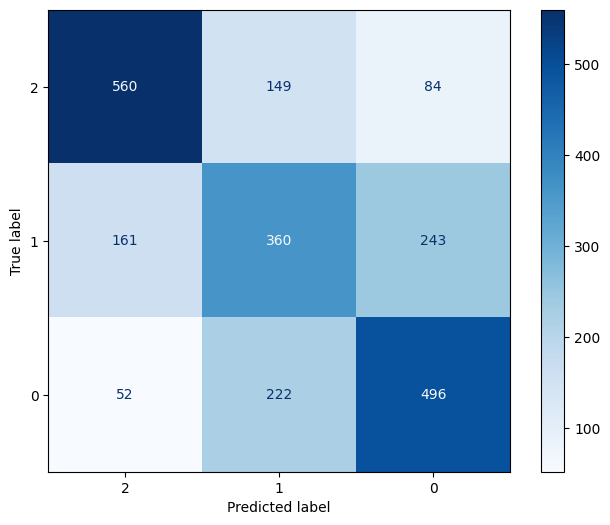

In [53]:
import matplotlib.pyplot as plt
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)

# Save the plot as an image file (e.g., PNG)
plt.savefig('confusion_matrix_TFIDF_LR.png')
plt.savefig('confusion_matrix_TFIDF_LR.svg')

# Optionally, display the plot
plt.show()